Updated October 26. Designs probes against a single gene. Uses the sequence with UTRs but without introns. Blasts against transcriptome with introns, transcriptome without introns, and intergenic databases to verify specificity. 
Author: Giacomo Glotzer. 

In [1]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import subprocess
import sys
sys.path.append('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/analysis')
from transcriptomics import * 
from hcr import *
from plotting import * 

# Specify blast databases
new_transcriptome_db_no_introns = "../raw-data/OBir/mRNA_no_introns/mRNA_no_introns"
new_transcriptome_db_yes_introns = "../raw-data/OBir/mRNA_yes_introns/mRNA_yes_introns"
all_intergenic_regions_db = '../raw-data/OBir/intergenics/all_intergenic_regions'
all_lncRNAs_db = '../raw-data/OBir/lncRNAs/all_ORs_antisense'

# Load genome
genome_path = "../raw-data/OBir/genome/Obir.assembly.v5.4.fasta"
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../raw-data/OBir/transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 

Initializing transcriptomics package
Initializing HCR package
Initializing plotting package


In [2]:
# set main directory for writing files 
main_directory = '../raw-data/OBir/single_gene_probe_design/'
if not os.path.exists(main_directory):
    os.makedirs(main_directory)

In [31]:
# Specify Gene 
gene_name = "Or5-9E213"

In [33]:
or_db.loc[or_db.gene_name == gene_name]

,chromosome,gene_name,tandem_array,rank,orientation
252,6,Or5-9E213,37,253,NaN


In [34]:
# Get gene 
gene = tr.get_gene(gene_name)
gene

Gene(name=Or5-9E213, id=Or5-9E213, transcripts=3, chromosome=Chr6, strand=+)

In [35]:
gene.transcripts

[Transcript(name=XM_011350360.3, 1203bp CDS, Chr6:10898300-10901757, exons=9, introns=8, utrs=0),
 Transcript(name=XM_020033802.2, 1083bp CDS, Chr6:10898300-10901757, exons=8, introns=7, utrs=0),
 Transcript(name=XM_020033803.2, 1035bp CDS, Chr6:10898303-10901757, exons=9, introns=8, utrs=0)]

In [36]:
len(gene.transcripts)

3

In [37]:
# Get transcript 
transcript = gene.get_transcript_longest_cds()
transcript 

Transcript(name=XM_011350360.3, 1203bp CDS, Chr6:10898300-10901757, exons=9, introns=8, utrs=0)

In [38]:
# Get chromosome 
chromosome = gene.chromosome
chromosome

'Chr6'

In [39]:
# Permitted off-targets
permitted_off_targets = []

In [40]:
# Off-target transcripts (from the same gene)
off_target_transcripts = [] 

In [41]:
# Set target 
gene.target_sequence = transcript.mrna_sequence # transcript.mrna_sequence
print(f"Sequence length: {len(gene.target_sequence)}")

Sequence length: 1848


In [42]:
# Export each gene sequence to a fasta file 
output_dir = os.path.join(main_directory, 'or_seq_blast_input')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

with open(f"{output_dir}/{gene.name}.fasta", 'w') as f: 
    f.write(f">{gene.name}\n{gene.target_sequence}")

In [43]:
## Blast genes against the transcriptome without introns (mature mRNA), transcriptome with introns (pre-mRNA), and intergenic regions 
input_dir = os.path.join(main_directory, 'or_seq_blast_input')
output_dir = os.path.join(main_directory, 'or_seq_blast_output')

# create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# get gene sequence path 
input_path = f"{input_dir}/{gene.name}.fasta"
# no introns 
output_path = f"{output_dir}/{gene.name}_blasted_no_introns.csv"
command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)
# yes introns
output_path = f"{output_dir}/{gene.name}_blasted_yes_introns.csv"
command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)
# intergenic 
output_path = f"{output_dir}/{gene.name}_blasted_intergenics.csv"
command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)

CompletedProcess(args="blastn -task blastn -query ../raw-data/OBir/single_gene_probe_design/or_seq_blast_input/Or5-9E213.fasta -db ../raw-data/OBir/intergenics/all_intergenic_regions -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out ../raw-data/OBir/single_gene_probe_design/or_seq_blast_output/Or5-9E213_blasted_intergenics.csv -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4", returncode=0)

In [44]:
length_thresh = 50 

## Iterate through blast results and annotate non-unique regions 
input_dir = os.path.join(main_directory, 'or_seq_blast_output')
output_dir = os.path.join(main_directory, 'or_seq_unique_regions') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# No introns
input_path = f"{input_dir}/{gene.name}_blasted_no_introns.csv"
blast_results_no_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_no_introns['source'] = 'no_introns'

# Yes introns
input_path = f"{input_dir}/{gene.name}_blasted_yes_introns.csv"
blast_results_yes_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_yes_introns['source'] = 'yes_introns'

# Yes introns
input_path = f"{input_dir}/{gene.name}_blasted_intergenics.csv"
blast_results_intergenics = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_intergenics['source'] = 'intergenics'

# Concatenate 
blast_results = pd.concat([blast_results_no_introns, blast_results_yes_introns, blast_results_intergenics], axis=0)

# remove rows where length < length_thresh 
blast_results = blast_results.loc[(blast_results['length'].values >= length_thresh), :]

# Add column for subject gene ID 
blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

# Add column for whether the query and subject gene are the same
blast_results['same_gene'] = blast_results['query_id'] == blast_results['subject_gene_id']

# Label hits to intergenic regions by extracting the tandem array number 
blast_results['intergenic_tandem_array'] = blast_results['subject_id'].apply(
    lambda x: int(x.split('-Or5')[0].split('T')[1]) # for intergenic regions
    if 'Chr' in x
    else ""
)

# Get location of intergenic hits 
blast_results['intergenic_location'] = blast_results['subject_id'].apply(
    lambda x: "Chr" + x.split('-Chr')[1] # for intergenic regions
    if 'Chr' in x
    else ""
)

# Get location of intergenic hits 
blast_results['intergenic_chr'] = blast_results['intergenic_location'].apply(
    lambda x: "Chr" + x.split('Chr')[1].split(':')[0] # for intergenic regions
    if 'Chr' in x
    else ""
)

# Get location of intergenic start 
blast_results['intergenic_start'] = blast_results['intergenic_location'].apply(
    lambda x: int(x.split('Chr')[1].split(':')[1].split('-')[0]) # for intergenic regions
    if 'Chr' in x
    else ""
)

# Get location of intergenic end 
blast_results['intergenic_end'] = blast_results['intergenic_location'].apply(
    lambda x: int(x.split('Chr')[1].split(':')[1].split('-')[1]) # for intergenic regions
    if 'Chr' in x
    else ""
)

# Overlapping with intergenic region? 
start, end = transcript.get_bounds()
blast_results['overlapping_with_intergenic'] = blast_results.apply(
    lambda x: overlapping(gene.chromosome, start, end, x['intergenic_chr'], x['intergenic_start'], x['intergenic_end']),
    axis=1
)

# permitted_off_targets 
blast_results['permitted_off_target'] = blast_results.apply(
    lambda x: any([keyword in x['subject_gene_id'] for keyword in permitted_off_targets]) if x['subject_gene_id'] != None else False,
    axis=1
)

# Label hits to the same gene that are off-targets because of their transcript identity
# Only considers hits that are exonic (for now)
blast_results['off_target_transcript'] = blast_results.apply(
    lambda x: x['same_gene'] 
              and any(q in x['subject_id'] for q in off_target_transcripts), 
              #and x['source'] == 'no_introns',
    axis=1
)

# Get off-targets
off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                    (blast_results['same_gene'] == False) & # off-targets only
                                    (blast_results['overlapping_with_intergenic'] == False) & 
                                    (blast_results['permitted_off_target'] == False), :]  # ignore overlapping intergenics 

off_targets = pd.concat([off_targets, blast_results.loc[blast_results['off_target_transcript'], :]], axis=0)

# Annotate off-targets 
sequence = gene.target_sequence
for j, row in off_targets.iterrows():
    sequence = sequence[:row['q_start']] + '-'*(row['q_end'] - row['q_start']) + sequence[row['q_end']:]
gene.unique_sequence = sequence 

# Save the blast results to the gene object 
gene.blast_results = blast_results

# Save the sequence to new file 
with open(f"{output_dir}/{gene.name}_unique.fasta", 'w') as f:
    f.write(f">{gene.name}\n")
    f.write(sequence)

print(f"Unique regions have been annotated and exported to {output_dir}")

Unique regions have been annotated and exported to ../raw-data/OBir/single_gene_probe_design/or_seq_unique_regions


In [45]:
sequence

'CATAATAATTATAATATGTAATAATATAATTTAATTGTATGTATATAAATACGTTTTAAAATACATACTTTATTGAACAATGTGTACCTTACTACGAGATGCCATATCAAAATTGAACGAGTGTATATACTAGGATAAGACTGAAATAAAACTGAAATTATATTGCTGAAGAAAAATAGGAAACTTTCTCTCTCTTATATATAAAGAAAAAACAGAGGGGAAAAAGATCGTTTATAGGAATATTTTCCAGAGAAAAATTCACATTTGTCAAATTGCCATAATGGGCCATAATTTATTCATGGCGTATTTTCAAGAATAGTTTTTTTATAATAGTAGTACGTATCTTACCGCTGCATTTCGTATCAAATTATGAGATGTTTGAATTAAAGAATTTATGTTATAAAGAAGAAGTGCGATCGATGAGTTTCTAGGTATGACAAGAGGGGGATGACTAAACTGACGATAGTTTCTCTGCAGTCAGATGTATCTAATGCTCGCAGAGATGATATTTTCTGTGATTCAATATTTCAATCTTAATCGGATTCTTCTGCTCATGATTGGATTGTGGCCTCAAAAACAAACTAAACTCGTACGATTACAAATAATTTTATGCTATTTTATCCTGACAAGTTTTATTGTAGTTCAGTTTATGACATTTGCGACTTCAAAGATCAGTCTGCAGTTGATCATCGATGTTTTTCCTGCCGCTTTCTTTTTCCTTTCCTACATGATAAAATACAGCTCATTTTATTTTAACCGCGATGTAGTAAAGTATTTACTAGATATAGTTCAACACACATATAACGAGTTAAAAGATGAGAGTGAAATTGCCATTATAAAAAAGCATTGGAATATTGCAAGACGTTATACTAAAGTACTAACAATATTCAGCATATTCGGTGTATTTGGACTTATCTCCGTTCCAATCTTGCCGCACATTATTGATGTTTCATGGCCTGCAAACAAATCTCGACGATGTTCATCGTCACAAATCTTGAC

In [46]:
off_targets

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,...,subject_gene_id,same_gene,intergenic_tandem_array,intergenic_location,intergenic_chr,intergenic_start,intergenic_end,overlapping_with_intergenic,permitted_off_target,off_target_transcript


In [47]:
blast_results

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,...,subject_gene_id,same_gene,intergenic_tandem_array,intergenic_location,intergenic_chr,intergenic_start,intergenic_end,overlapping_with_intergenic,permitted_off_target,off_target_transcript
0,Or5-9E213,ref|XM_011350360.3|,XM_011350360,100.0,1848,0,0,1,1848,1,...,Or5-9E213,True,,,,,,False,False,False
1,Or5-9E213,ref|XM_020033803.2|,XM_020033803,100.0,1204,0,0,645,1848,699,...,Or5-9E213,True,,,,,,False,False,False
2,Or5-9E213,ref|XM_020033803.2|,XM_020033803,100.0,643,0,0,4,646,1,...,Or5-9E213,True,,,,,,False,False,False
3,Or5-9E213,ref|XM_020033802.2|,XM_020033802,100.0,1082,0,0,767,1848,647,...,Or5-9E213,True,,,,,,False,False,False
4,Or5-9E213,ref|XM_020033802.2|,XM_020033802,100.0,646,0,0,1,646,1,...,Or5-9E213,True,,,,,,False,False,False
0,Or5-9E213,ref|XM_020033802.2|,XM_020033802,100.0,646,0,0,1,646,1,...,Or5-9E213,True,,,,,,False,False,False
1,Or5-9E213,ref|XM_020033802.2|,XM_020033802,100.0,265,0,0,885,1149,1632,...,Or5-9E213,True,,,,,,False,False,False
2,Or5-9E213,ref|XM_020033802.2|,XM_020033802,100.0,213,0,0,1636,1848,3246,...,Or5-9E213,True,,,,,,False,False,False
3,Or5-9E213,ref|XM_020033802.2|,XM_020033802,100.0,152,0,0,1355,1506,2585,...,Or5-9E213,True,,,,,,False,False,False
4,Or5-9E213,ref|XM_020033802.2|,XM_020033802,100.0,133,0,0,1504,1636,3035,...,Or5-9E213,True,,,,,,False,False,False


In [48]:
# Determine how many probes fit on each gene 
sequence = gene.unique_sequence 
probes, regions, positions = design_hcr_probes(sequence, "B1")

print(f"There is enough space for {len(probes)} probes on {gene.name}")

There is enough space for 25 probes on Or5-9E213


In [49]:
# Specify amplifier 
amplifier = "B2"

In [50]:
# Specify how many probes 
n_probes = 30

In [51]:
# Export excel sheet with probes and excel sheet with probe binding regions 

# Design probes
sequence = gene.unique_sequence 
probes, regions, positions = design_hcr_probes(sequence, amplifier)

# Randomly select n_probes_per_gene probes 
np.random.seed(1)
if len(probes) < n_probes:
    indices = range(len(probes))
else: 
    indices = np.random.choice(range(len(probes)), n_probes, replace=False)
probes = [probes[i] for i in indices]
regions = [regions[i] for i in indices]

# Save probes and regions to gene object
gene.probes = probes
gene.regions = regions

# Collapse probes 
probes_collapsed = [probe for sublist in probes for probe in sublist]

# Get date 
today = pd.Timestamp.now().strftime('%Y-%m-%d')

# Export probes 
output_dir = os.path.join(main_directory, 'IDT_sheets')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/{gene_name}-{amplifier}-{transcript.name}-{today}.xlsx"
# Create dataframe
df = pd.DataFrame({'Sequence': probes_collapsed})
# Add pool name column 
df['Pool name'] = f'{gene_name}-{amplifier}-{transcript.name}'
df = df[['Pool name', 'Sequence']]
df.to_excel(output_path, index=False)
print(f"{len(probes_collapsed)} probes have been exported to {output_path}")


# Export probe binding regions
output_dir = os.path.join(main_directory, 'probe_binding_regions_sheets') 
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/{gene_name}-{amplifier}-{transcript.name}-regions-{today}.xlsx"
# Make a vector of the gene names for each probe 
target_genes = [gene.name for _ in range(len(probes))]
df = pd.DataFrame({'Gene': [gene.name for _ in range(len(probes))], 
                   'Region': regions, 
                   'Probe 1': [probe[0] for probe in gene.probes], 
                   'Probe 2': [probe[1] for probe in gene.probes]})
df.to_excel(output_path, index=False)

50 probes have been exported to ../raw-data/OBir/single_gene_probe_design/IDT_sheets/Or5-9E213-B2-XM_011350360.3-2025-05-24.xlsx


In [52]:
# Export all_regions to individual fasta files 

output_dir = os.path.join(main_directory, 'probe_region_blast_input')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Export all_regions to individual fasta files in output_dir 
for i, region in enumerate(regions): 
    with open(f"{output_dir}/region-{i}.fasta", 'w') as f: 
        f.write(f">region-{i}\n{region}")

In [53]:
# Blast all regions against the transcriptome

input_dir = os.path.join(main_directory, 'probe_region_blast_input')
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Blast each region against the transcriptome
for i, region in enumerate(regions): 
    input_path = f"{input_dir}/region-{i}.fasta"

    # Blast against transcriptome without introns
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against transcriptome with introns
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against intergenics 
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -1 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

print("All regions have been blasted against the transcriptome")

All regions have been blasted against the transcriptome


In [54]:
# Load in blast results
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 
all_blast_results = []
for i, region in enumerate(regions):
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'no_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'yes_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'intergenics'
    all_blast_results.append(blast_results)

In [55]:
# Check for non-unique regions

num_hits_over_thresh = 0
length_thresh = 50
mismatch_thresh = 5 
all_off_targets = pd.DataFrame()

# Iterate through blast results 
for i, blast_results in enumerate(all_blast_results):
    if len(blast_results) == 0: 
        continue

    # Add column for subject gene ID 
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

    # Add column for whether the query and subject gene are the same
    blast_results['same_gene'] = gene_name == blast_results['subject_gene_id']

    
    # Label hits to intergenic regions by extracting the tandem array number 
    blast_results['intergenic_tandem_array'] = blast_results['subject_id'].apply(
        lambda x: int(x.split('-Or5')[0].split('T')[1]) # for intergenic regions
        if 'Chr' in x
        else ""
    )

    # Get location of intergenic hits 
    blast_results['intergenic_location'] = blast_results['subject_id'].apply(
        lambda x: "Chr" + x.split('-Chr')[1] # for intergenic regions
        if 'Chr' in x
        else ""
    )

    # Get location of intergenic hits 
    blast_results['intergenic_chr'] = blast_results['intergenic_location'].apply(
        lambda x: "Chr" + x.split('Chr')[1].split(':')[0] # for intergenic regions
        if 'Chr' in x
        else ""
    )

    # Get location of intergenic start 
    blast_results['intergenic_start'] = blast_results['intergenic_location'].apply(
        lambda x: int(x.split('Chr')[1].split(':')[1].split('-')[0]) # for intergenic regions
        if 'Chr' in x
        else ""
    )

    # Get location of intergenic end 
    blast_results['intergenic_end'] = blast_results['intergenic_location'].apply(
        lambda x: int(x.split('Chr')[1].split(':')[1].split('-')[1]) # for intergenic regions
        if 'Chr' in x
        else ""
    )

    # Overlapping with intergenic region? 
    start, end = transcript.get_bounds()
    blast_results['overlapping_with_intergenic'] = blast_results.apply(
        lambda x: overlapping(gene.chromosome, start, end, x['intergenic_chr'], x['intergenic_start'], x['intergenic_end']),
        axis=1
    )

    # Label hits to the same gene that are off-targets because of their transcript identity
    # Only considers hits that are exonic (for now)
    blast_results['off_target_transcript'] = blast_results.apply(
        lambda x: x['same_gene'] 
                and any(q in x['subject_id'] for q in off_target_transcripts), 
                #and x['source'] == 'no_introns',
        axis=1
    )

    # permitted_off_targets 
    blast_results['permitted_off_target'] = blast_results.apply(
        lambda x: any([keyword in x['subject_gene_id'] for keyword in permitted_off_targets]) if x['subject_gene_id'] != None else False,
        axis=1
    )

    # Get off-targets
    off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                    (blast_results['mismatches'].values <= mismatch_thresh) & # mismatch threshold
                                    (blast_results['same_gene'] == False) & # off-targets only
                                    (blast_results['permitted_off_target'] == False) &
                                    (blast_results['overlapping_with_intergenic'] == False), :]  # ignore overlapping intergenics 
    
    
    off_targets = pd.concat([off_targets, blast_results.loc[blast_results['off_target_transcript'], :]], axis=0)

    # Add to the all_off_targets dataframe
    all_off_targets = pd.concat([all_off_targets, off_targets])

    # Update num_hits_over_thresh   
    num_hits_over_thresh += len(off_targets)

print(f"Found {num_hits_over_thresh} off-target hits with length >= {length_thresh}bp, mismatches <= {mismatch_thresh}")

Found 0 off-target hits with length >= 50bp, mismatches <= 5


In [56]:
all_off_targets

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,...,subject_gene_id,same_gene,intergenic_tandem_array,intergenic_location,intergenic_chr,intergenic_start,intergenic_end,overlapping_with_intergenic,off_target_transcript,permitted_off_target


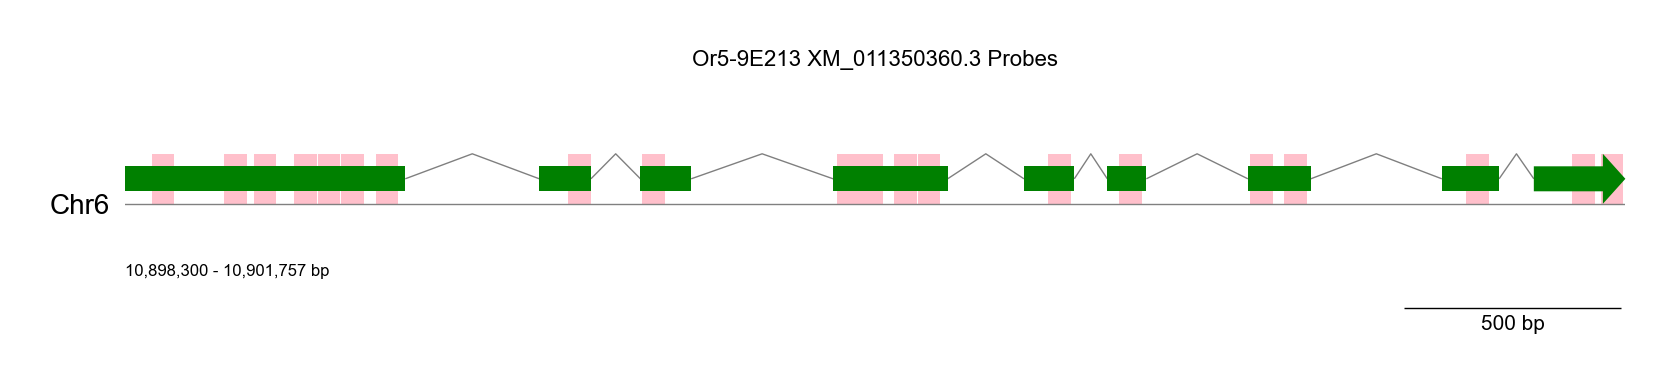

In [58]:
white_plotting()
# Create a new GenomeViz object
gv = GenomeViz(track_align_type="center", theme="light")
gv.set_scale_bar(ymargin=0.5)

# Get bounds 
chromosome = gene.chromosome
bounds = transcript.get_bounds() 
min_start = int(bounds[0])
max_end = int(bounds[1])
track = gv.add_feature_track(chromosome, segments = (min_start, max_end))
track.add_sublabel()

# Add exons to plot
exon_bounds = [[int(exon.position[0]), int(exon.position[1])] for exon in transcript.exons]
exon_bounds = sorted(exon_bounds, key=lambda x: x[0])
strand = int(np.where(transcript.strand == '+', 1, -1) )
track.add_exon_feature(exon_bounds, strand, plotstyle='arrow', arrow_shaft_ratio = 0.5, patch_kws=dict(fc="green", ec="none", alpha=1), intron_patch_kws=dict(ec="black", lw=1, alpha=0.5), label='')

# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()

# Add probe regions to plot on opposite strand 
for region in regions:
    positions = [m.start() for m in re.finditer(region, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + len(region), 1, plotstyle="box", label = '', ec="none", fc="pink", alpha=1)

# Add reverse complement 
reverse_seq = reverse_complement(forward_seq)
for region in regions:
    positions = [m.start() for m in re.finditer(region, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - len(region), max_end - position, -1, plotstyle="box", label = '', ec="none", fc="pink", alpha=1)

fig = gv.plotfig()

plt.title(f"{gene_name} {transcript.name} Probes", y=1.8, fontsize=16)
plt.show()

# Export figure 
output_dir = os.path.join(main_directory, 'probe_regions_plot')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figure
output_path = f"{output_dir}/{gene_name}-{amplifier}-{transcript.name}-probes.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)

